# License

    Jupyter notebook for accessing CUDA
    Copyright (C) 2018 Andre.Brodtkorb@ifi.uio.no, changed in October by André Brodtkorb

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

#Import packages we need
import numpy as np
import pycuda.compiler as cuda_compiler
from pycuda.gpuarray import GPUArray
import pycuda.driver as cuda_driver

from matplotlib import pyplot as plt

import IPythonMagic

In [2]:
#For timing
from Timer import Timer

#For logging
import logging

In [3]:
import pytest
from ipytest import run_pytest, clean_tests

In [4]:
%setup_logging
%cuda_context_handler context

Python version 3.6.6 (default, Sep 12 2018, 18:26:19) 
[GCC 8.0.1 20180414 (experimental) [trunk revision 259383]]
Registering context in user workspace
Creating context
PyCUDA version 2018.1.1
CUDA version (9, 1, 0)
Driver version 10000
Using 'Tesla K80' GPU
 => compute capability: (3, 7)
 => memory: 9819 / 11441 MB available
Created context handle <51662720>
Using CUDA cache dir /home/ubuntu/jupyter_notebooks/Fabio/MilanoGPU2018/notebooks/cuda_cache


In [5]:
cuda_kernel = """
__global__ void matrixVectorKernel(double* c, double* A, double* b, int a_rows, int a_cols) {
    unsigned int j = blockIdx.x*blockDim.x + threadIdx.x; //more efficient threads aligned horizontally
    
    //Out of bounds check
    if (j > a_rows) {
        return;
    }
    
    //Compute inner product of row of A with column of B
    float sum = 0.0f;
    for (int i=0; i<a_cols; ++i) {
        unsigned int k = j*a_cols + i;
        sum += A[k] * b[i];
    }
    
    //Write to global memory
    c[j] = sum;
}
"""
module = cuda_compiler.SourceModule(cuda_kernel)
kernel = module.get_function("matrixVectorKernel");

In [7]:
def gpuMatrixVector(a, b):
    context.synchronize()
    
    #Upload data to the device
    #NOTE: We need to make sure that a=(a_rows, a_columns)
    # and that b=(a_colmuns, 1) (column vector)
    # and that c=(a_rows, 1)
    with Timer("Data allocation") as t:
        a_g = GPUArray(a.shape, np.float64)
        b_g = GPUArray(b.shape, np.float64)
        #Allocate output data
        c_g = GPUArray(a.shape[0], np.float64)
        context.synchronize()
        
    with Timer("A upload") as t:
        a_g.set(a)
        context.synchronize()
        
    with Timer("B upload") as t:
        b_g.set(b)
        context.synchronize()
    
    
    #NOTE: We need to change this so that the grid*block is x = 1, y = number of rows in A
    block_size = (128, 1, 1) #These need to be [x, y, z]
    grid_size = (int(np.ceil(a.shape[0] / 128)), 1, 1)

    print("Block size is " + str(block_size))
    print("Grid size is " + str(grid_size))
    
    #Execute program on device
    with Timer("Kernel execution") as t:
        kernel(c_g, a_g, b_g, np.int64(a.shape[0]), np.int32(a.shape[1]), block=block_size, grid=grid_size)
        context.synchronize()
        
    #Copy data from device to host
    with Timer("Allocate c") as t:
        c = np.empty((a.shape[0],1), dtype=np.float64)
    
    #insert timing function
    with Timer("Download", logging.INFO) as t:
        c_g.get(c)
        context.synchronize()
    
    #Return our computed matrix-vector product
    return c #To skip printing of c

In [8]:
nx = np.array([200, 400, 800, 1600, 3200, 6400, 8000])
ny = nx

print(nx, ny)

[ 200  400  800 1600 3200 6400 8000] [ 200  400  800 1600 3200 6400 8000]


Nx = 200


Create test data: 17.380953 ms
Data allocation: 0.774145 ms
A upload: 0.267267 ms
B upload: 0.398159 ms
Kernel execution: 0.162125 ms
Allocate c: 0.010490 ms
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:42: DeprecationWarning: get() between arrays of different shape is deprecated and will be removed in PyCUDA 2017.x
Download: 0.527620 ms
Run whole function: 6.282330 ms


Block size is (128, 1, 1)
Grid size is (2, 1, 1)
Nx = 400


Create test data: 4.790545 ms
Data allocation: 0.545502 ms
A upload: 0.468254 ms
B upload: 0.206232 ms
Kernel execution: 0.418425 ms
Allocate c: 0.010729 ms
Download: 0.235558 ms
Run whole function: 5.952120 ms


Block size is (128, 1, 1)
Grid size is (4, 1, 1)
Nx = 800


Create test data: 16.221523 ms
Data allocation: 0.481606 ms
A upload: 0.889301 ms
B upload: 0.247002 ms
Kernel execution: 0.101805 ms
Allocate c: 0.008583 ms
Download: 0.160217 ms
Run whole function: 6.894588 ms


Block size is (128, 1, 1)
Grid size is (7, 1, 1)
Nx = 1600


Create test data: 50.631046 ms
Data allocation: 0.539541 ms
A upload: 2.978325 ms
B upload: 0.277042 ms
Kernel execution: 0.376225 ms
Allocate c: 0.008583 ms
Download: 0.207424 ms
Run whole function: 12.372732 ms


Block size is (128, 1, 1)
Grid size is (13, 1, 1)
Nx = 3200


Create test data: 207.813978 ms
Data allocation: 0.641108 ms
A upload: 11.002541 ms
B upload: 0.219584 ms
Kernel execution: 0.117302 ms
Allocate c: 0.009775 ms
Download: 0.211716 ms
Run whole function: 28.442860 ms


Block size is (128, 1, 1)
Grid size is (25, 1, 1)
Nx = 6400


Create test data: 814.950466 ms
Data allocation: 1.075029 ms
A upload: 42.931080 ms
B upload: 0.209332 ms
Kernel execution: 0.137091 ms
Allocate c: 0.010014 ms
Download: 0.149965 ms
Run whole function: 91.259718 ms


Block size is (128, 1, 1)
Grid size is (50, 1, 1)
Nx = 8000


Create test data: 1276.815653 ms
Data allocation: 1.260519 ms
A upload: 67.568064 ms
B upload: 0.684977 ms
Kernel execution: 0.146627 ms
Allocate c: 0.009537 ms
Download: 0.139713 ms
Run whole function: 141.777754 ms


Block size is (128, 1, 1)
Grid size is (63, 1, 1)
[   40000   160000   640000  2560000 10240000 40960000 64000000]
[  6   5   6  12  28  91 141]


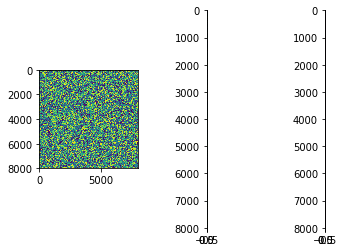

In [11]:
times = np.empty_like(nx)
for i in range(len(nx)):
    print("Nx = " + str(nx[i]), flush=True)
    #Size of our test
    test_size = (nx[i], ny[i])

    #Create test input / output data
    with Timer("Create test data") as t:
        a = np.random.random(test_size).astype(np.float64)
        b = np.random.random((test_size[1], 1)).astype(np.float64)

    with Timer('Run whole function', logging.INFO) as t:
        c = gpuMatrixVector(a, b)
    times[i] = t.msecs
    
print(nx*ny)
print(times)


fig = plt.figure()
plt.subplot(1,3,1)
plt.imshow(a)
plt.subplot(1,3,2)
plt.imshow(b)
plt.subplot(1,3,3)
plt.imshow(c)
fig.show()

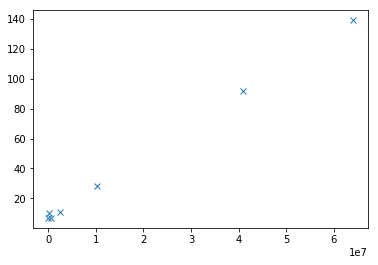

In [10]:
plt.figure()
plt.plot(nx*ny, times, 'x')

In [15]:
#Compute reference using Numpy
c_ref = np.dot(a, b)

#Sum of absolute differences
sad = np.sum(np.abs(c - c_ref))

#Print result
# print("C   = ", c)
# print("Ref = ", c_ref)
print("Sad = %.30f" % sad)
print("Per element error: " + str(sad / test_size[1]))

Sad = 0.000000000000000000000000000000
Per element error: 0.0


In [16]:
clean_tests() #this initializes the pytest framework

def test_gpuMatrixVector():
    #Let us test a matrix of size 1x1
    a = np.ones((1,1), dtype=np.float64)
    b = 2*np.ones((1,1), dtype=np.float64)
    c = gpuMatrixVector(a, b)
    assert c == pytest.approx(2.0) #make sure it is approximate otherwise it will fail
    
    #Test that the inner product works
    a = np.ones((1,2), dtype=np.float64)
    b = 2*np.ones((2,1), dtype=np.float64)
    c = gpuMatrixVector(a, b)
    assert c == pytest.approx(4.0)
    
    #Test a general matrix
    test_size = (4, 3)
    a = np.random.random(test_size).astype(np.float64)
    b = np.random.random((test_size[1], 1)).astype(np.float64)
    c = gpuMatrixVector(a, b)
    assert c == pytest.approx(np.dot(a, b), rel = 1e-3)
    
run_pytest(filename='MatrixVectorTesting.ipynb', pytest_options=['-vvv']) #vvv: be really really verbose! We need info

============================= test session starts ==============================
platform linux -- Python 3.6.6, pytest-3.8.2, py-1.6.0, pluggy-0.7.1 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /home/ubuntu/jupyter_notebooks/Fabio/MilanoGPU2018/notebooks, inifile:
collecting ... collected 1 item

MatrixVectorTesting.py::test_gpuMatrixVector <- <ipython-input-16-21c36f96d5a4> 

Memory copy time: 0.162601 ms
Memory copy time: 0.143051 ms
Memory copy time: 0.140905 ms


PASSED [100%]

=============================== warnings summary ===============================
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: get() between arrays of different shape is deprecated and will be removed in PyCUDA 2017.x
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: get() between arrays of different shape is deprecated and will be removed in PyCUDA 2017.x
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: get() between arrays of different shape is deprecated and will be removed in PyCUDA 2017.x

-- Docs: https://docs.pytest.org/en/latest/warnings.html
===================== 1 passed, 3 warnings in 0.03 seconds =====================


0